# SVC Backtesting

In [1]:
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
import yfinance as yf
from sklearn.preprocessing import StandardScaler

# Set random seed
np.random.seed(42)

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def compute_stochastic_oscillator(high, low, close, k_period=14, d_period=3):
    lowest_low = low.rolling(window=k_period).min()
    highest_high = high.rolling(window=k_period).max()
    stoch_k = 100 * (close - lowest_low) / (highest_high - lowest_low)
    stoch_d = stoch_k.rolling(window=d_period).mean()
    return stoch_k, stoch_d

def add_features_with_macro(ticker="^GSPC", start="2020-01-30", end="2024-01-01", prediction_horizon=5, big_move_threshold=0.005):
    # Download price data
    df = yf.download(ticker, start=start, end=end)

    # Download macro indicators
    vix = yf.download('^VIX', start=start, end=end)
    tnx = yf.download('^TNX', start=start, end=end)

    # Cleaning the multiindexed columns
    df.columns = [col if isinstance(col, str) else col[0] for col in df.columns]

    # Mid-price & returns
    df['Mid'] = (df['High'] + df['Low']) / 2
    df['Return'] = df['Close'].pct_change()
    df['Mid_Return'] = df['Mid'].pct_change()

    # Technical indicators
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Return'].rolling(window=10).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['RSI'] = compute_rsi(df['Close'])
    df['MACD'], df['MACD_signal'] = compute_macd(df['Close'])
    df['Stoch_K'], df['Stoch_D'] = compute_stochastic_oscillator(df['High'], df['Low'], df['Close'])

    # Macro indicators (align by date index)
    df['VIX_Close'] = vix['Close']
    df['TNX_Close'] = tnx['Close']

    # Future return target
    df['Future_Return'] = df['Close'].shift(-prediction_horizon) / df['Close'] - 1

    # Multi-class label: big moves only
    df['Target'] = np.where(df['Future_Return'] > big_move_threshold, 1,
                    np.where(df['Future_Return'] < -big_move_threshold, -1, 0))

    # Feature columns (can customize if needed)
    df['X_MA5'] = (df['Close'] - df['MA5']) / df['Close']
    df['X_MA10'] = (df['Close'] - df['MA10']) / df['Close']
    df['X_MA20'] = (df['Close'] - df['MA20']) / df['Close']
    df['X_MA5_10'] = (df['MA5'] - df['MA10']) / df['Close']
    df['X_MA10_20'] = (df['MA10'] - df['MA20']) / df['Close']
    df['X_Volatility'] = df['Volatility']
    df['X_Momentum'] = df['Momentum']
    df['X_Return'] = df['Return']
    df['X_Return_5'] = df['Return'].rolling(5).sum()
    df['X_VOL_CHG'] = df['Volume'].pct_change(5)
    df['X_RSI'] = df['RSI']
    df['X_MACD'] = df['MACD']
    df['X_MACD_signal'] = df['MACD_signal']
    df['X_Stoch_K'] = df['Stoch_K']
    df['X_Stoch_D'] = df['Stoch_D']
    df['X_VIX'] = df['VIX_Close']
    df['X_TNX'] = df['TNX_Close']

    return df  # no dropna(), keep full index

# Helper functions to extract features and labels
def get_X(data):
    feature_columns = [col for col in data.columns if col.startswith('X_')]
    return data[feature_columns].values

def get_y(data):
    return data.Target.values

# Apply features
df = add_features_with_macro()
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])



/Users/aroncheng/backtest-env/lib/python3.9/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
from sklearn.svm import SVC

class strategy_class(Strategy):
    def init(self):
        self.model = SVC(probability=True, random_state=42)
        self.features = [col for col in self.data.df.columns if col.startswith("X_")]
        self.df = add_features_with_macro().fillna(method='ffill').fillna(method='bfill')

        self.pred = self.I(lambda: np.zeros(len(self.data)), name='pred')  # for plotting
        self.predictions = []
        self.actuals = []

    def next(self):
        i = len(self.data)
        if i < 200:
            return

        # Define train and test data
        train = self.df.iloc[i-200:i]
        test = self.df.iloc[[i-1]]

        X_train = train[self.features].values
        y_train = train["Target"].values
        X_test = test[self.features].values
        y_true = test["Target"].values[0]

        # Fit and predict
        self.model.fit(X_train, y_train)
        prediction = self.model.predict(X_test)[0]

        # Track predictions for evaluation
        if prediction in [-1, 0, 1]:
            self.predictions.append(prediction)
            self.actuals.append(int(y_true))

        # Update indicator for chart
        self.pred[-1] = prediction

        # Trading logic
        if prediction == 1:
            if not self.position.is_long:
                self.position.close()
                self.buy()
        elif prediction == -1:
            if not self.position.is_short:
                self.position.close()
                self.sell()


In [3]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_strategy(y_true, y_pred):

    print("📈 Evaluation Metrics")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision (macro):", round(precision_score(y_true, y_pred, average='macro'), 4))
    print("F1 Score (macro):", round(f1_score(y_true, y_pred, average='macro'), 4))

    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Down (-1)', 'Neutral (0)', 'Up (1)'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [4]:

bt = Backtest(df, strategy_class, cash=10000, commission=0.001)
backtest = bt.run()
backtest


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/46/zqdj50yj7l759m_vn_js8z0w0000gn/T/ipykernel_16814/2627944835.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df = add_features_with_macro().fillna(method='ffill').fillna(method='bfill')


Start                     2020-01-30 00:00:00
End                       2023-12-29 00:00:00
Duration                   1429 days 00:00:00
Exposure Time [%]                    75.37994
Equity Final [$]                  21616.37662
Equity Peak [$]                   21670.45669
Commissions [$]                    2256.14643
Return [%]                          116.16377
Buy & Hold Return [%]                45.25956
Return (Ann.) [%]                    21.75211
Volatility (Ann.) [%]                15.59626
CAGR [%]                             14.56132
Sharpe Ratio                           1.3947
Sortino Ratio                         2.69075
Calmar Ratio                          2.64471
Alpha [%]                           112.47317
Beta                                  0.08154
Max. Drawdown [%]                    -8.22477
Avg. Drawdown [%]                    -1.51455
Max. Drawdown Duration      184 days 00:00:00
Avg. Drawdown Duration       12 days 00:00:00
# Trades                          

📈 Evaluation Metrics
Accuracy: 0.5266
Precision (macro): 0.4124
F1 Score (macro): 0.3786


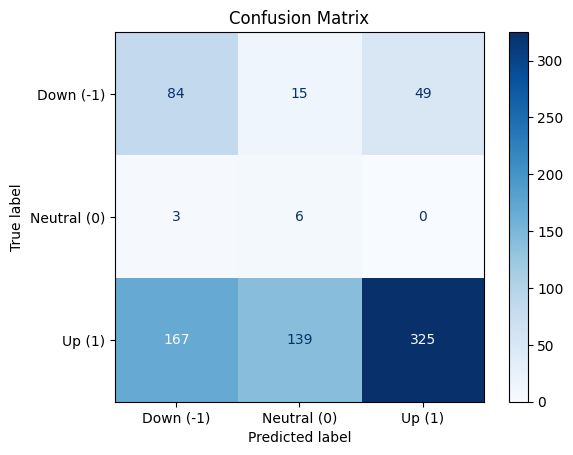

In [5]:
predictions = backtest._strategy.predictions
actuals = backtest._strategy.actuals
evaluate_strategy(predictions, actuals)

In [6]:
bt.plot()

/Users/aroncheng/backtest-env/lib/python3.9/site-packages/backtesting/_plotting.py:701: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/Users/aroncheng/backtest-env/lib/python3.9/site-packages/backtesting/_plotting.py:701: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1367', ...)